# IMDb Early Ratings Bias
Jordan Long, February 2022

## Outline
- [Summary](#Summary)
- [Importing the Data and Exploratory Data Analysis](#Importing-the-Data-and-Exploratory-Data-Analysis)
    - [How big of an impact do bot users have on our dataset?](#bot_exploration)
    - [How do users who leave a lot of ratings differ from other users?](#user_differences)
    - [What timeframes does our dataset cover?](#timeframes)
    - [How are Ratings Distributed?](#ratings_distribution)
    - [What is the Distribution of Movie Popularities?](#movie_popularities)
    - [How did Joker's rating evolve over time?](#joker)
    - [Augmenting Data with Title, Format, Genre, Year, and Runtime](#augmenting)
    - [How Similar are Ratings Submitted With Written Reviews to General Ratings?](#external_validity)
    - [Estimating Release Dates and Reducing Our Dataset](#estimating_dates)
    - [Exploring Rating Variation over Time](#ratings_over_time)
    - [Creating our Final Panel Dataset](#panel)
- [Appendix: Exploring the Initial Dataset](#appendix)

## Summary

I often look at [IMDb](imdb.com) ratings to choose which movies to watch. However, I've noticed that when new movies come out, their ratings tend to slowly decline. One possible explanation for this is that the first people to watch and review the movie are the movie's fans, who are more inclined than the typical movie watcher to rate the movie favourably. This analysis seeks to explore and quantify this phenomenon.

To do this, I explore a dataset of ratings left by users who write written reviews for movies on IMDb, along with the user and movie IDs, and the date of the rating. Using the most popular x movies and assuming that a movie's release month coincides with the month of the first review, I construct a panel of average movie ratings in the months following their release. Then, using a fixed-effect regression model that controls for seasonality and movie-specific effects, I estimate the extent to which the IMDb score of an average movie declines in each month following the movie's release.

I find that the average movie's IMDb score declines by 0.5 points out of 10 in the first four months following the movie's release, with the long term amount of decline roughly stablizing at 0.76 points out of 10 by three years after the movie's release. The plot below captures the decay in ratings over the first 24 months after a movie's release.

One caveat with this approach is that users who leave a written review are not representative of all users that leave ratings, having a tendency to leave higher ratings. This reduces the applicability of my findings to the actual IMDb rating that I use to pick movies.

![title](IMDbRatingDecline.png)

These results are immediately useful for using early IMDb ratings to assess whether or not to watch a movie, as it gives me a rule of thumb for predicting where a movie's rating may end up. Further, the finding that ratings largely stabilize within three years of their release can help in framing the problem for a more refined predictive model.

While perhaps obvious, a final takeaway from this analysis is that ratings on review aggregators like IMDb are subject to large selection biases from who leaves the ratings, and so perhaps I should give less weight to them in my own decision making... Recommendation approaches like collaborative filtering implicitly take this into consideration, and so perhaps my Netflix recommendations are in fact a better indication of what movies I am most likely to enjoy.

In [133]:
import pandas as pd
import numpy as np # TODO: check if I used this
from matplotlib import pyplot as plt # TODO: check if I used this
import seaborn as sns # TODO: check if I used this
import os
from datetime import datetime

# Importing the Data and Exploratory Data Analysis

In order to explore how movie ratings evolve over time, I need data on IMDb movie ratings over time. I found such a dataset, containing IMDb users, movies, ratings, and dates for written reviews from IMDb at https://doi.org/10.21227/br41-bd49. However, this source doesn't explicitly describe how the data was collected so I explore the data to figure out what I'm working with.

In [2]:
data_folder = ".."

In [3]:
raw_data = np.load(os.path.join(data_folder, "Dataset.npy"))
raw_data_backup = raw_data

In [4]:
clean_data = pd.DataFrame(raw_data)
clean_data = clean_data[0].str.split(',')
users = clean_data.str.get(0)
movies = clean_data.str.get(1)
rating = clean_data.str.get(2)
date = clean_data.str.get(3)
clean_data = pd.concat([users, movies, rating, date], axis=1)
clean_data.columns = ["user", "movie", "rating", "date"]
clean_data["rating"] = clean_data["rating"].astype(int)
clean_data["date"] = pd.to_datetime(clean_data["date"])
clean_data_backup = clean_data

In [5]:
clean_data.dtypes

user              object
movie             object
rating             int64
date      datetime64[ns]
dtype: object

In [6]:
clean_data.head()

,user,movie,rating,date
0,ur4592644,tt0120884,10,2005-01-16
1,ur3174947,tt0118688,3,2005-01-16
2,ur3780035,tt0387887,8,2005-01-16
3,ur4592628,tt0346491,1,2005-01-16
4,ur3174947,tt0094721,8,2005-01-16


In [7]:
clean_data.describe()

,rating
count,4.669820e+06
mean,6.758660e+00
std,2.978028e+00
min,1.000000e+00
25%,5.000000e+00
50%,8.000000e+00
75%,9.000000e+00
max,1.000000e+01


We have 4.6 million ratings, from 1.5 million users and 350,000 movies. Also, there's a user with over 24,000 ratings, which seems very high. This makes me concerned that there may be bots skewing the results in the data. To explore this and other potential data quality issues, I went more in depth into each of the four variables. My key takeaways are presented here, with further analysis presented in [Appendix: Exploring the Initial Dataset](#Appendix:-Exploring-the-Initial-Dataset).

<a id="bot_exploration"></a>
### How big of an impact do bot users have on our dataset?

If bots composed a significant portion of the ratings, we might expect to find users that have left a large number of reviews, or users that have rated the same movie numerous times. I begin by exploring this.

In [8]:
user_review_counts = clean_data.groupby("user")["rating"].count().sort_values(ascending=False)
(user_review_counts >= 10).mean()

0.0330201075479677

Only 3.3% of users leave 10 or more reviews.

In [9]:
user_review_counts.head()

user
ur2467618     24145
ur20552756    16817
ur2483625     16715
ur0482513     13213
ur2898520     12677
Name: rating, dtype: int64

And yet several of the top users have left over 10,000 reviews.

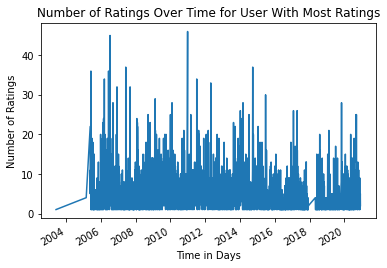

In [97]:
superuser = clean_data[clean_data["user"] == "ur2467618"]
superuser["date"].value_counts().plot(
    title="Number of Ratings Over Time for User With Most Ratings", 
    xlabel="Time in Days",
    ylabel="Number of Ratings",
);

In [11]:
superuser.groupby(date).count()["rating"].describe()

count    4560.000000
mean        5.294956
std         4.362100
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        46.000000
Name: rating, dtype: float64

In [12]:
4560 / 365

12.493150684931507

The user with the most reviews does have a lot of ratings (an average of 5.3 per day for 12.5 years worth of days!), but they seem to be fairly consistent. In fact, looking at their IMDb profile at https://www.imdb.com/user/ur2467618 reveals that they are employed as a writer, and their reviews seem substantive! This gives me more faith that the ratings in this dataset come from real users rather than bots. Another reason to trust the data is that the ratings in our dataset accompany written reviews, and it is harder for bots to write reviews than simply leave ratings.

Moreover, they have left 27,121 reviews as of January 2022, so it seems likely that all of their reviews prior to December 2020 are captured in the data. This makes it plausible that our dataset consists of all reviews left on IMDb prior to December 2020 (the last date in our dataset), rather than just a sample.

I now look at how many users are leaving multiple reviews for the same movie. We might expect bots to leave multiple reviews for the same movie to boost the movie's IMDb rating. At the same time, it is probably not uncommon for someone to review a movie on their second or third watch.

In [13]:
intermediate = clean_data.groupby("user")["movie"]
duped_user_movie = (intermediate.count() - intermediate.nunique())
(duped_user_movie > 0).mean()

0.010816161276595177

duped_user_movie has users, and the number of ratings they've left minus the number of unique movies they've rated. It is greater than zero whenever a user has rated a movie more than once. This shows that only 1% of users have left multiple reviews for the same movie.

In [14]:
duped_user_movie.sort_values(ascending=False)

user
ur18044142    60
ur6387867     55
ur49848930    44
ur89246644    42
ur3836774     41
              ..
ur19223537     0
ur19223533     0
ur1922348      0
ur19223392     0
ur9999988      0
Name: movie, Length: 1499238, dtype: int64

In [15]:
super_duper = clean_data[clean_data["user"] == "ur18044142"]

In [16]:
super_duper["movie"].value_counts()

tt1844624    4
tt2372162    3
tt3952222    3
tt2741602    3
tt1837492    3
            ..
tt5989218    1
tt5758778    1
tt7339826    1
tt6337930    1
tt5149490    1
Name: movie, Length: 1162, dtype: int64

Again, exploring the IMDb page of the user with the most duplicate reviews for movies reveals that they seem like a legitimate reviewer, with no more than 4 ratings for the same movie. See https://imdb.com/user/ur18044142. In conclusion, it seems that bots have little impact on this dataset.

<a id="user_differences"></a>
### How do users who leave a lot of ratings differ from other users?

In [17]:
user_ratings = clean_data.groupby("user")["rating"].mean()

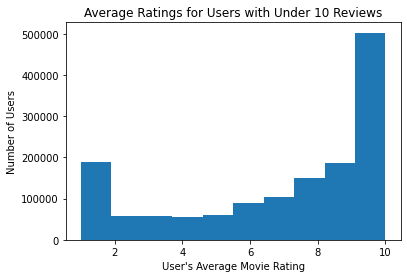

In [98]:
ax = user_ratings[user_review_counts < 10].plot(
    kind="hist", 
    title="Average Ratings for Users with Under 10 Reviews",
    xlabel="User's Average Movie Rating",
    ylabel="Number of Users"
)
ax.set_xlabel("User's Average Movie Rating")
ax.set_ylabel("Number of Users");

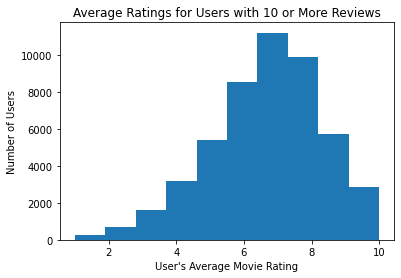

In [99]:
ax = user_ratings[user_review_counts >= 10].plot(
    kind="hist", 
    title="Average Ratings for Users with 10 or More Reviews",
    xlabel="User's Average Movie Rating",
    ylabel="Number of Users"
)
ax.set_xlabel("User's Average Movie Rating")
ax.set_ylabel("Number of Users");

Users that don't tend to leave reviews are much more likely to leave a polarized review (1 or 10) than reviewers who leave reviews regularly. Perhaps people who rarely leave reviews are incited to leave a review by an intense emotion following a film. It is likely that a similar behavioural pattern exists for people leaving IMDb ratings without written reviews.

<a id="timeframes"></a>
### What timeframes does our dataset cover?

In [20]:
clean_data["date"].describe()

<ipython-input-20-e9b0a023f55f>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  clean_data["date"].describe()


count                 4669820
unique                   8028
top       2019-05-20 00:00:00
freq                     7291
first     1998-07-27 00:00:00
last      2020-12-03 00:00:00
Name: date, dtype: object

We have observations spanning July 1998 to December 3 2020

In [21]:
22*365 # rough estimate of days between December 3 1998 and December 3 2020

8030

There are approximately 5 months worth of days in which there were no reviews.

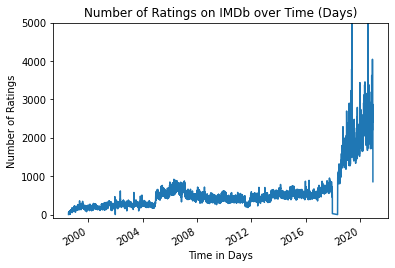

In [100]:
clean_data.groupby("date")["rating"].count().plot(
    ylabel="Number of Ratings", 
    xlabel="Time in Days",
    title="Number of Ratings on IMDb over Time (Days)",
    ylim=(-100,5000),
);

There are three main noticably different time periods in our data. The first, from 1998 through to the end of 2004 have a growing but small number of ratings. The years 2005 through 2017 have a stable but larger number of ratings over time. Then, it appears that there were no ratings in the first three months of 2018, followed by a sustained increase in the number of ratings over time through to the end of 2020. The times spanning these periods is shown in more detail below.

In [23]:
clean_data["year"] = clean_data["date"].dt.year
clean_data["month"] = clean_data["date"].dt.month

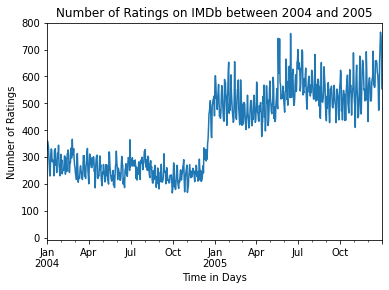

In [101]:
clean_data[(clean_data["year"] == 2005) | (clean_data["year"] == 2004)].groupby("date")["rating"].count().plot(
    ylim=(-10,800),
    xlabel="Time in Days",
    ylabel="Number of Ratings",
    title="Number of Ratings on IMDb between 2004 and 2005"
);

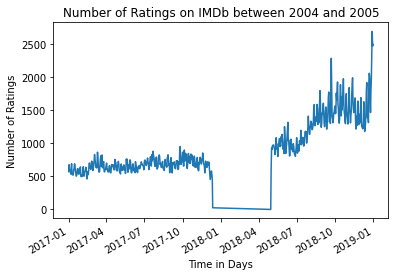

In [102]:
clean_data[(clean_data["year"] == 2017) | (clean_data["year"] == 2018)].groupby("date")["rating"].count().plot(
    xlabel="Time in Days",
    ylabel="Number of Ratings",
    title="Number of Ratings on IMDb between 2004 and 2005"
);

There are also some days with an exceptionally large number of ratings, which were clipped in the graph of number of reviews over time. They are as follows:

In [26]:
clean_data["date"].value_counts().head(5)

2019-05-20    7291
2020-07-25    5773
2020-07-24    4542
2020-11-21    4045
2019-05-13    3788
Name: date, dtype: int64

In [27]:
clean_data[clean_data["date"] == "20 May 2019"]["movie"].value_counts().head(5)

tt6027920    5145
tt0944947     432
tt6146586      63
tt4154796      51
tt6027916      41
Name: movie, dtype: int64

The unusually high number of ratings on this day is driven by the final Game of Thrones episode! See https://www.imdb.com/title/tt6027920/.

In [28]:
clean_data[clean_data["date"] == "25 July 2020"]["movie"].value_counts().head(5)

tt8110330     3389
tt10230426      69
tt9784456       63
tt8210856       52
tt10003008      26
Name: movie, dtype: int64

In [29]:
clean_data[clean_data["date"] == "24 July 2020"]["movie"].value_counts().head(5)

tt8110330     2468
tt9784456      127
tt11730940      88
tt8210856       51
tt12344410      36
Name: movie, dtype: int64

The unusually high number of ratings on these days is driven by the the Indian film Dil Bechara (a remake of The Fault in Our Stars). See https://www.imdb.com/title/tt8110330/.

This highlights that our dataset contains more than just Hollywood films - T.V. shows and foreign films as well. This will be explored in more detail later in the analysis.

<a id="ratings_distribution"></a>
### How are Ratings Distributed?

We previously looked at the way that users' average ratings are distributed. Here we explore the overall ratings distribution, as well as ratings for films.

This presents the overall ratings distribution. Ratings of 10 and 1 are quite popular, and ratings of 8 are otherwise the most common.

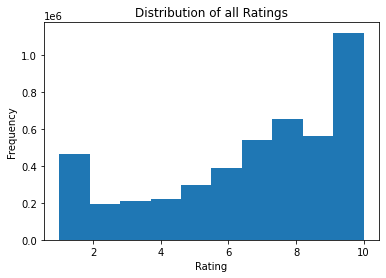

In [103]:
ax = clean_data["rating"].plot(kind="hist")
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of all Ratings");

If we look by movie, there are far fewer movies with mean ratings of 10 or 1.

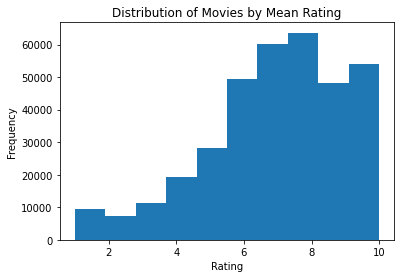

In [104]:
ax = clean_data.groupby("movie")["rating"].mean().plot(kind="hist")
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Movies by Mean Rating");

<a id="movie_popularities"></a>
### What is the Distribution of Movie Popularities?

In [32]:
num_movie_ratings = clean_data["movie"].value_counts()

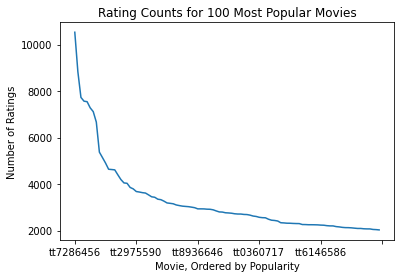

In [105]:
num_movie_ratings[:100].plot(
    title="Rating Counts for 100 Most Popular Movies",
    xlabel="Movie, Ordered by Popularity",
    ylabel="Number of Ratings",
);

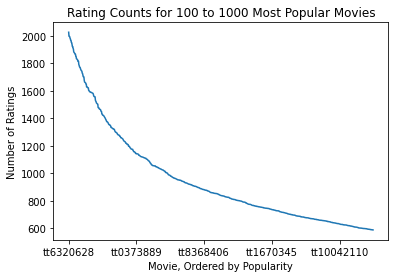

In [106]:
num_movie_ratings[100:1000].plot(
    title="Rating Counts for 100 to 1000 Most Popular Movies",
    xlabel="Movie, Ordered by Popularity",
    ylabel="Number of Ratings",
);

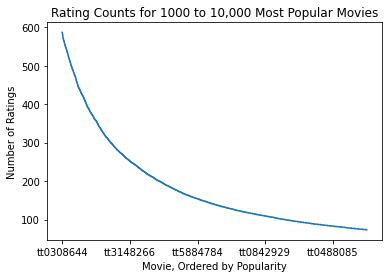

In [107]:
num_movie_ratings[1000:10000].plot(
    title="Rating Counts for 1000 to 10,000 Most Popular Movies",
    xlabel="Movie, Ordered by Popularity",
    ylabel="Number of Ratings",
);

Clearly, movie popularity follows a very long-tailed distribution.

In [36]:
(num_movie_ratings > 10).mean()

0.15009868730223377

In [37]:
(num_movie_ratings > 100).mean()

0.02145772395466935

In [38]:
(num_movie_ratings > 100).sum()

7534

Out of ~350K movies, only 15% have more than 10 reviews, and only 7.5K have more than 100 reviews.

<a id="joker"></a>
### How did Joker's rating evolve over time?

Remember that our overall goal in this analysis is to examine the extent to which ratings decline over time. Here I briefly examine this phenomenon for the movie with the most reviews - Joker.

In [39]:
num_movie_ratings.head(2)

tt7286456    10534
tt4154796     8835
Name: movie, dtype: int64

In [40]:
joker = clean_data[clean_data["movie"] == "tt7286456"]

I visualize the evolution of ratings here in several ways. A better way to visualize this data would be to have a weighted rolling average of ratings by day, but these are sufficient to show that a declining trend exists. The first two visualization aggregates the mean ratings by day, which gives too much weight to days with few observations. Both the rolling mean and expanding mean show evidence of declining ratings.

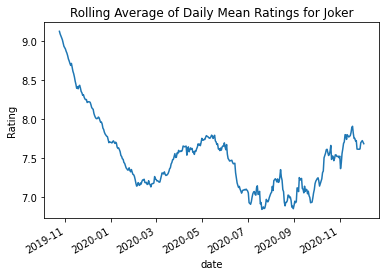

In [108]:
joker.groupby("date")["rating"].mean().rolling(50).mean().plot(
    ylabel="Rating",
    title="Rolling Average of Daily Mean Ratings for Joker",
);

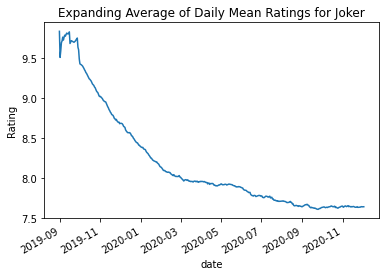

In [109]:
joker.groupby("date")["rating"].mean().expanding().mean().plot(
    ylabel="Rating",
    title="Expanding Average of Daily Mean Ratings for Joker",
);

The next two plots ignore the date of the rating and just compute rolling and expanding mean ratings. Besides not being correlated with dates, another limitation of these graphs are that the ratings on a given date may not be listed in our data in the order they were written (though this appears to be the case).

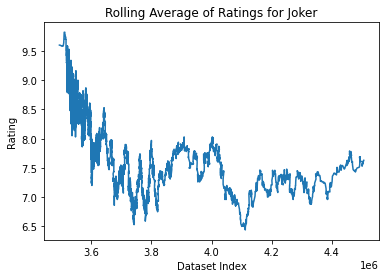

In [110]:
joker.sort_values("date")["rating"].rolling(100).mean().plot(
    ylabel="Rating",
    xlabel="Dataset Index",
    title="Rolling Average of Ratings for Joker"
);

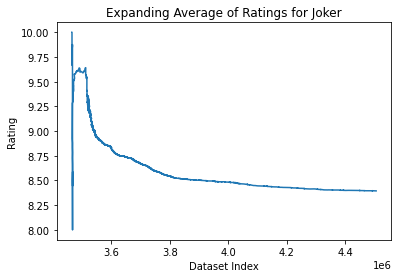

In [111]:
joker.sort_values("date")["rating"].expanding().mean().plot(
    ylabel="Rating",
    xlabel="Dataset Index",
    title="Expanding Average of Ratings for Joker"
);

<a id="augmenting"></a>
### Augmenting Data with Title, Format, Genre, Year, and Runtime

As mentioned in the above exploratory data analysis, the dataset contains more than just movie ratings. Since these are the objects that I am most curious about, I would like to drop everything in the dataset that is not a movie. To find which movie_ids are associated with movies, I bring in a dataset on title basic info from the IMDb interfaces page at https://www.imdb.com/interfaces/.

In [64]:
basic_info = pd.read_csv("../title.basics.tsv", sep="\t")

/Users/jordanlong/.pyenv/versions/3.8.5/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [65]:
basic_info.shape

(8468617, 9)

In [66]:
basic_info.head(2)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"


This has information on 8.5M titles. Since we are only interested in titles that are present in our dataset, we get rid of all of the other titles.

In [67]:
basic_info = basic_info[basic_info["tconst"].isin(clean_data["movie"])]

In [68]:
basic_info.shape

(350259, 9)

Oddly, there are 850 movies in our clean dataset that don't have an entry in the official IMDb dataset. However, they only account for 3.5K ratings, so this mystery is unlikely to heavily skew our results.

In [80]:
missing_tconsts = set(clean_data["movie"]) - set(basic_info["tconst"])
len(missing_tconsts)

850

In [81]:
missing_movies = clean_data[clean_data["movie"].isin(missing_tconsts)]
missing_movies.shape

(3440, 7)

After confirming there are no duplicate entries, we merge this data with our clean dataset.

In [71]:
basic_info["tconst"].duplicated().sum()

0

In [73]:
augmented_data = pd.merge(left=clean_data, right=basic_info[basic_info["titleType"] == "movie"], left_on="movie", right_on="tconst")

Below we see that only a third of the unique titles in our dataset are movies, indicating that our above analysis might not be representative of IMDb movies.

In [69]:
basic_info["titleType"].value_counts()

movie           139631
tvEpisode       100281
short            35937
tvSeries         27340
tvMovie          19333
video            15085
tvMiniSeries      4767
videoGame         4099
tvSpecial         3071
tvShort            715
Name: titleType, dtype: int64

We've also dropped around 1.2 million reviews by only looking at movies.

In [75]:
clean_data.shape

(4669820, 7)

In [74]:
augmented_data.shape

(3444441, 16)

<a id="external_validity"></a>
### How Similar are Ratings Submitted With Written Reviews to General Ratings?

All of our analysis is based on ratings submitted to IMDb with an accompanying written review. If these ratings are not representative of IMDb ratings more generally, our conclusions from this analysis will not be applicable to the IMDb score that appears on the website. I explore this with another dataset from the IMDb interfaces page, containing movie titles, the weighted average of all user ratings, and the number of votes the title has received.

For each movie, I calculate the average rating from the written reviews, and see how it compares to the overall average rating.

In [88]:
ratings = pd.read_csv("../title.ratings.tsv", sep="\t")
ratings = ratings[ratings["tconst"].isin(clean_data["movie"])]

In [88]:
review_ratings = augmented_data.groupby("tconst").agg(
    {"rating": "mean", 
     "primaryTitle": "max", 
     "startYear": "max",
     "runtimeMinutes": "max",
     "user": "count"}
)
review_ratings.rename(columns={"user": "numReviews"}, inplace=True)
review_ratings.rename(columns={"rating": "averageReview"}, inplace=True)

In [89]:
rating_comparison = review_ratings.merge(ratings, left_index=True, right_on="tconst")
rating_comparison["diffRating"] = rating_comparison["averageRating"] - rating_comparison["averageReview"]

The following two plots show the difference in average scores between ratings and reviews. It's clear that scores from reviews tend to be slightly higher than scores from ratings (since the mean difference is approximately -0.5). There is considerable dispersion in the amount of this difference.

The second plot shows the same trend, though by filtering for movies with over 25000 votes we are likely getting rid of movies with only a few ratings or reviews.

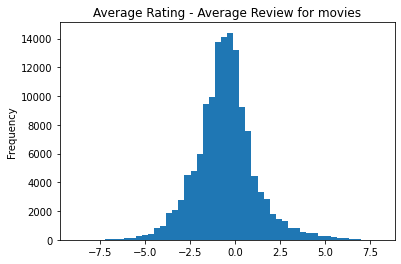

In [128]:
rating_comparison["diffRating"].plot(kind="hist", bins=50, xlabel="Difference in Rating", title="Average Rating - Average Review for movies");

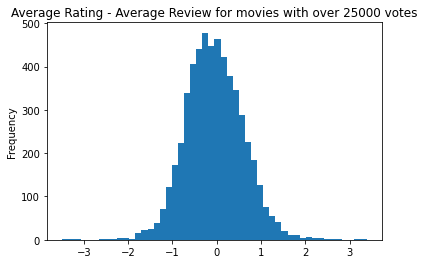

In [129]:
rating_comparison[rating_comparison["numVotes"] > 25000]["diffRating"].plot(kind="hist", bins=50, xlabel="Difference in Rating", title="Average Rating - Average Review for movies with over 25000 votes");

In [344]:
augmented_data.to_csv("211210cleaned_movie_ratings.csv")

In [345]:
rating_comparison.to_csv("211210movie_info.csv")

<a id="estimating_dates"></a>
### Estimating Release Dates and Reducing Our Dataset

To assess how ratings change over time, we need movie release dates. IMDb gives this to us at a year level, but we want a more granular estimate. To find this, we're going to assume that the first review falls around the release of a movie.

In [120]:
rating_comparison = rating_comparison.merge(augmented_data.groupby("movie")["date"].min(), left_on="tconst", right_on="movie").rename(columns={"date": "first_review"})

In [122]:
rating_comparison.head(1)

,averageReview,primaryTitle,startYear,runtimeMinutes,numReviews,tconst,averageRating,numVotes,diffRating,first_review
0,8.666667,The Story of the Kelly Gang,1906,70,6,tt0000574,6.1,737,-2.566667,2001-07-07


In [125]:
rating_comparison = rating_comparison[rating_comparison["startYear"] != "\\N"]
rating_comparison["startYear"] = rating_comparison["startYear"].astype(int)

<ipython-input-125-75c959f6a932>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_comparison["startYear"] = rating_comparison["startYear"].astype(int)


In [126]:
augmented_data = augmented_data[augmented_data["startYear"] != "\\N"]
augmented_data["startYear"] = augmented_data["startYear"].astype(int)

The following plot shows our estimated number of movie releases over time for movies released in 2005 or later. We use 2005 as our cutoff because, as previously discovered, there was a large jump in reviewing behaviour on IMDb before that date.

There is a large jump in new releases sometime in 2018. This is because, as previously discovered, our dataset contains no reviews from April 2018. Thus any movie that was actually released in April 2018 will be counted as released in May 2018.

It should also be noted that there are some movies with reviews prior to 2005, perhaps due to advanced screenings.

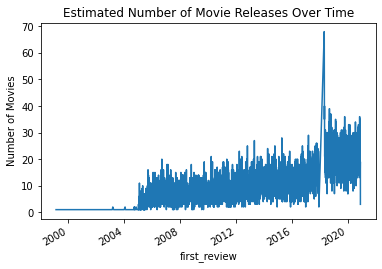

In [131]:
rating_comparison[rating_comparison["startYear"] >= 2005].groupby("first_review")["tconst"].count().plot(title="Estimated Number of Movie Releases Over Time", ylabel="Number of Movies");

In order to account for this, we get rid of movies estimated to be released in May 2018, and all pre-2005 movies.

In [134]:
rating_comparison = rating_comparison[(rating_comparison["first_review"] >= datetime(2018,6,1)) | (rating_comparison["first_review"] < datetime(2018,1,1))]

In [135]:
rating_comparison = rating_comparison[rating_comparison["startYear"] >= 2005]
rating_comparison = rating_comparison[rating_comparison["first_review"] >= datetime(2005,1,1)]

Note that our assumption that first reviews track movie releases is more likely to hold true for movies with more reviews, so we'll also filter our data for movies with at least 100 reviews. (100 was chosen arbitrarily)

In [137]:
review_cutoff = 100

In [138]:
rating_comparison["numReviews"].describe()

count    61498.000000
mean        31.407802
std        161.082727
min          1.000000
25%          1.000000
50%          4.000000
75%         12.000000
max      10534.000000
Name: numReviews, dtype: float64

In [139]:
(rating_comparison["numReviews"] >= review_cutoff).sum()

3530

In [141]:
clean_movies = rating_comparison[rating_comparison["numReviews"] >= 100]

In [143]:
clean_reviews = augmented_data[augmented_data["movie"].isin(clean_movies["tconst"])]

In [144]:
clean_reviews.shape

(1389228, 16)

Note that although we have reduced our dataset of movies considerably (down to 3.5K), we have only reduced our datset of reviews by approximately one third. Further, by reducing our dataset to the most popular, somewhat recently released films, our results are likely to be more applicable to the new, popular movies that I am likely to care about.

<a id="ratings_over_time"></a>
### Exploring Rating Variation over Time

Are ratings changing over time in our dataset? It seems as though they've been relatively stable, so we don't necessarily need to account for long term seasonality in our model.

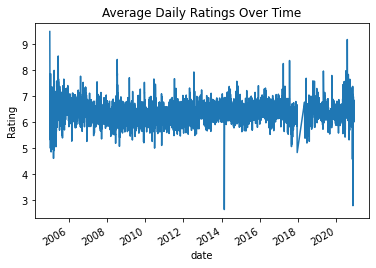

In [147]:
clean_reviews.groupby("date")["rating"].mean().plot(title="Average Daily Ratings Over Time", ylabel="Rating");

Is there month-to-month seasonality in ratings? It appears that there is, with a difference in mean ratings of 0.3 between July and September. It seems odd that people's ratings would be so seasonal, but it's possible that the best films are released in the summer when audiences are larger.

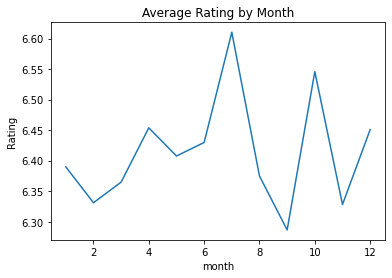

In [150]:
clean_reviews.groupby("month")["rating"].mean().plot(title="Average Rating by Month", ylabel="Rating");

To further explore this pattern, we look at the number of new releases by month. It turns out that September, the month with the lowest average rating, is also the month with the most new releases. 

Further research indicates that September is a high season for film festivals, with festivals like the Venice film festival and Toronto International Film Festival taking place. More movies are likely released during film festivals than average, with less prestigious films being released. Critics and festival goers may also be harsher than regular audiences.

<ipython-input-156-bbbf869b9f05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_movies["first_review_month"] = clean_movies["first_review"].dt.month


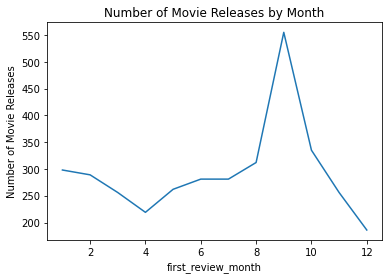

In [156]:
clean_movies["first_review_month"] = clean_movies["first_review"].dt.month
clean_movies.groupby("first_review_month")["averageReview"].count().plot(title="Number of Movie Releases by Month", ylabel="Number of Movie Releases");

Is there much day-to-day variation in movie releases? To construct a panel dataset, I'm going to group movie ratings by the month of their release. However, movies released at the end of the month will be counted as having fewer ratings in their first month, and thus more variable estimates. I want some idea of how commonly this occurs.

I find that there is a relatively uniform distribution of movie releases by day of month. This means that there will be some fairly noisy estimates of first-month ratings. I might expect these estimates to be biased upwards because of the hypothesis that fans go to movies first, and rate higher.

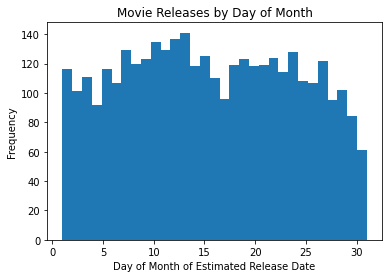

In [159]:
ax = clean_movies["first_review"].dt.day.plot(kind="hist",bins=31, xlabel="day of month", title="Movie Releases by Day of Month")
ax.set_xlabel("Day of Month of Estimated Release Date");

<a id="panel"></a>
### Creating our Final Panel Dataset

In order to estimate the decay in ratings over time using a linear model, I transform the dataset such that each row corresponds to a month for a specific movie. Grouping by month means that we will estimate how much ratings change each month, which likely gives more precise estimates than grouping by day since release.

In [187]:
clean_reviews = clean_reviews.merge(clean_movies[["first_review", "tconst"]], how="left", on="tconst")

clean_reviews["year_month"] = 100*clean_reviews["date"].dt.year + clean_reviews["date"].dt.month

clean_reviews["first_review_year_month"] = 100*clean_reviews["first_review"].dt.year + clean_reviews["first_review"].dt.month

clean_reviews["first_review_year"] = clean_reviews["first_review"].dt.year

clean_reviews["first_review_month"] = clean_reviews["first_review"].dt.month

clean_reviews["first_review_month_offset"] = (clean_reviews["year"] - clean_reviews["first_review_year"])*12 + clean_reviews["month"] - clean_reviews["first_review_month"]

In [194]:
panel = clean_reviews.groupby(["movie", "first_review_month_offset"])[["runtimeMinutes", "rating", "month", "year", "year_month", "first_review_year", "first_review_month", "first_review_year_month"]].agg({"runtimeMinutes": "count", "rating": "sum", "month": "mean", "year": "mean", "year_month": "mean", "first_review_month": "mean", "first_review_year": "mean", "first_review_year_month": "mean"})

panel["cumulative_reviews"] = panel.groupby(level=0)["runtimeMinutes"].cumsum()

panel["cumsum_ratings"] = panel.groupby(level=0)["rating"].cumsum()

panel["cumavg_review"] = panel["cumsum_ratings"] / panel["cumulative_reviews"]

panel = panel.reset_index().rename(columns={"runtimeMinutes": "num_reviews", "rating": "sum_ratings"})

panel["2018_or_later"] = (panel["year"] > 2018)

In [201]:
panel

,movie,first_review_month_offset,num_reviews,sum_ratings,month,year,year_month,first_review_month,first_review_year,first_review_year_month,cumulative_reviews,cumsum_ratings,cumavg_review,2018_or_later
0,tt0120667,0,8,60,6,2005,200506,6,2005,200506,8,60,7.500000,False
1,tt0120667,1,507,3315,7,2005,200507,6,2005,200506,515,3375,6.553398,False
2,tt0120667,2,76,444,8,2005,200508,6,2005,200506,591,3819,6.461929,False
3,tt0120667,3,16,92,9,2005,200509,6,2005,200506,607,3911,6.443163,False
4,tt0120667,4,16,91,10,2005,200510,6,2005,200506,623,4002,6.423756,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176511,tt9900782,9,2,17,7,2020,202007,10,2019,201910,180,1620,9.000000,True
176512,tt9900782,10,6,52,8,2020,202008,10,2019,201910,186,1672,8.989247,True
176513,tt9900782,12,13,112,10,2020,202010,10,2019,201910,199,1784,8.964824,True
176514,tt9900782,13,8,57,11,2020,202011,10,2019,201910,207,1841,8.893720,True


How do individual movies' ratings evolve? Running this cell randomly samples a movie and shows how its rating evolved in the months following its release.

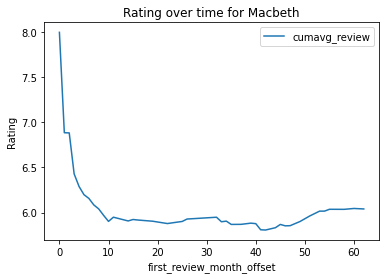

In [237]:
curmovie = panel["movie"].sample().values[0]

panel[panel["movie"] == curmovie].plot(x="first_review_month_offset", y="cumavg_review", ylabel="Rating", title="Rating over time for " + clean_movies[clean_movies["tconst"] == curmovie]["primaryTitle"].values[0]);

In [179]:
panel.to_csv("211215clean_movie_panel.csv")

The actual modelling is performed in the R markdown document. Details on the modelling choices can be found in the accompanying pdf.

<a id="appendix"></a>
## Appendix: Exploring the Initial Dataset

In [46]:
clean_data = clean_data_backup

We first explore users

In [47]:
user_review_counts = clean_data.groupby("user")["rating"].count().sort_values(ascending=False)
user_review_counts.describe()

count    1.499238e+06
mean     3.114796e+00
std      4.934654e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.414500e+04
Name: rating, dtype: float64

In [48]:
user_review_counts.head()

user
ur2467618     24145
ur20552756    16817
ur2483625     16715
ur0482513     13213
ur2898520     12677
Name: rating, dtype: int64

In [49]:
(user_review_counts >= 10).sum()

49505

In [50]:
(user_review_counts > 100).sum()

3153

In [51]:
(user_review_counts > 1000).sum()

235

In summary, we have 235 users with over 1K reviews, 3K users with over 100 reviews, 50K users with over 10 reviews, and 1.6 million users in total.

In the main analysis we looked at users who left a lot of reviews overall. What about users who leave a lot of ratings on the same day?

In [52]:
clean_data["userdate"] = clean_data["user"] + clean_data["date"].astype(str)

In [53]:
user_day_ratings = clean_data.groupby("userdate")["rating"].count()

In [54]:
user_day_ratings.sort_values(ascending=False)

userdate
ur439492882019-07-20    442
ur760625732020-03-31    245
ur161610132008-03-04    236
ur626604312019-02-18    231
ur760625732020-06-14    230
                       ... 
ur19800922013-02-23       1
ur19800922013-03-02       1
ur19800922013-04-16       1
ur19800922013-04-28       1
ur99999882008-10-17       1
Name: rating, Length: 3726439, dtype: int64

I looked into the first one here, and they seem to be legitimate ratings - probably just a dump of this person's opinions.

In [55]:
(user_day_ratings > 10).sum()

8574

In [56]:
(user_day_ratings > 100).sum()

54

It is exceedingly rare for a user to leave more than 10 ratings on the same day, occurring only 8,574 times out of 3.7 million observations.

### Ratings by Year, Month

In [57]:
clean_data["year"] = clean_data["date"].dt.year
clean_data["month"] = clean_data["date"].dt.month

Text(0, 0.5, 'Number of Ratings')

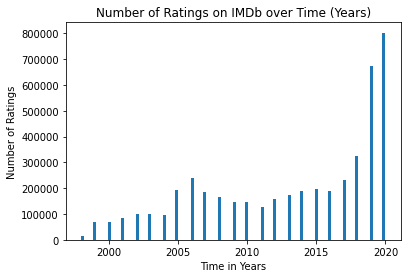

In [58]:
ax = clean_data["year"].plot(kind="hist", bins=100, title="Number of Ratings on IMDb over Time (Years)")
ax.set_xlabel("Time in Years")
ax.set_ylabel("Number of Ratings")

Text(0, 0.5, 'Number of Ratings')

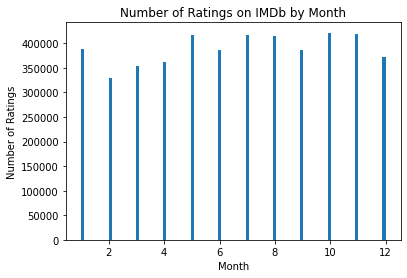

In [59]:
ax = clean_data["month"].plot(kind="hist", bins=100, title="Number of Ratings on IMDb by Month")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Ratings")

Are there some movies that got more duplicate reviews from users?

In [60]:
duped_ratings = clean_data[clean_data[["user", "movie"]].duplicated()]

In [61]:
duped_ratings["movie"].value_counts()

tt10350626    379
tt7743400     273
tt6027920     185
tt4154796     140
tt7784604     136
             ... 
tt5265980       1
tt2408430       1
tt5814534       1
tt0120257       1
tt0266238       1
Name: movie, Length: 9075, dtype: int64

In [62]:
clean_data[clean_data["movie"] == "tt10350626"].shape

(4906, 7)

There is nothing too crazy here. The top is an Indian movie called Gunjan Saxena: The Kargil Girl, with 379 duplicated reviews (that is, reviews from users who have reviewed the movie more than once). This is out of 4906 total reviews. Again, it seems that bots don't have an outsized role in reviews

For the sake of curiosity, I want to know the distribution of ratings among our selection of the 3.5K movies with popular reviews.

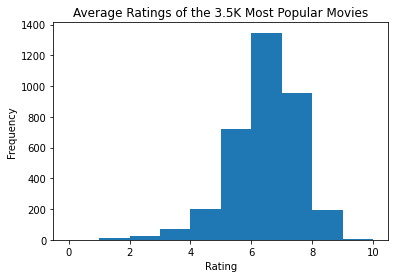

In [169]:
ax = clean_movies["averageRating"].plot(kind="hist", bins=[i for i in range(11)], title="Average Ratings of the 3.5K Most Popular Movies")
ax.set_xlabel("Rating");

I was also curious what the highest and lowest rated movies are:

In [179]:
clean_movies.sort_values("averageRating")

,averageReview,primaryTitle,startYear,runtimeMinutes,numReviews,tconst,averageRating,numVotes,diffRating,first_review,first_review_month
90901,1.196347,321 Action,2020,100,219,tt13423846,1.0,9376,-0.196347,2020-11-09,11
131466,1.769671,Sadak 2,2020,133,699,tt7886848,1.1,93196,-0.669671,2020-08-28,8
134869,1.287982,Hanum & Rangga,2018,90,441,tt9165634,1.2,3530,-0.087982,2018-11-11,11
115921,3.259494,Kirk Cameron's Saving Christmas,2014,79,158,tt4009460,1.4,15596,-1.859494,2014-11-13,11
58860,2.237288,Foodfight!,2012,91,118,tt0249516,1.6,10501,-0.637288,2012-06-17,6
...,...,...,...,...,...,...,...,...,...,...,...
75352,8.670366,The Dark Knight,2008,152,6668,tt0468569,9.0,2442962,0.329634,2008-07-06,7
123222,9.761194,That Vitamin Movie,2016,86,268,tt5624252,9.1,954,-0.661194,2017-03-22,3
82181,9.601365,Soorarai Pottru,2020,153,1465,tt10189514,9.1,99814,-0.501365,2020-11-12,11
122214,9.213333,Mirror Game,2016,147,150,tt5354160,9.1,25223,-0.113333,2016-09-28,9


How are number of reviews distributed over the months following release? Clearly there is a steep decline in the number of reviews as time wears on.

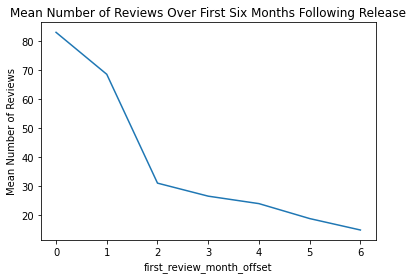

In [203]:
panel[panel["first_review_month_offset"] <= 6].groupby("first_review_month_offset")["num_reviews"].mean().plot(title="Mean Number of Reviews Over First Six Months Following Release", ylabel="Mean Number of Reviews");

Question: would our results change much if we group the first and second months together? (if the first month sometimes has very few data points due to movies being released near the end of the month, doing this would give more precise estimates)